# Phase retrieval

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(42)

## Model

In [2]:
from tramp.experiments import TeacherStudentScenario
from tramp.models import PhaseRetrieval

In [3]:
phase_retrieval = PhaseRetrieval(
    N=100, alpha=2.5, ensemble_type="complex_gaussian", prior_type="gaussian", mean_prior=1
)
print(f"phase_retrieval = {phase_retrieval}")

phase_retrieval = PhaseRetrieval(
  ensemble=ComplexGaussianEnsemble(M=250,N=100),
  prior=GaussianPrior(size=(2, 100),mean=1,var=1),
  linear=ComplexLinearChannel(W_name=F,Nx=250,Nz=100,ravel=False,precompute_svd=True),
  output=ModulusChannel()
)


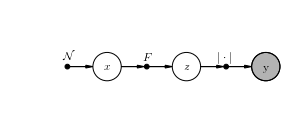

In [4]:
scenario = TeacherStudentScenario(phase_retrieval)
scenario.setup()
scenario.student.daft()

In [5]:
# checking that it can predict
scenario.infer()

/Users/antoinebaker/Documents/projects/ml_physics/tramp/likelihoods/modulus_likelihood.py:46: RuntimeWarning: invalid value encountered in cdouble_scalars
  b_normed = np.where(b==0, np.zeros_like(bz), bz/b)


In [6]:
from tramp.utils.misc import array2complex
x_true = array2complex(scenario.x_true["x"])
x_pred = array2complex(scenario.x_pred["x"])
print(
    f"mse_ep={scenario.mse_ep} mse_se={scenario.mse_se} mse={scenario.mse}\n"
    f"n_iter_ep={scenario.n_iter_ep} n_iter_se={scenario.n_iter_se}"
)

mse_ep={'x': 1.0070934221007022e-06} mse_se={'x': 1.2295500073644661e-06} mse={'x': 0.035626653765000064}
n_iter_ep=35 n_iter_se=33


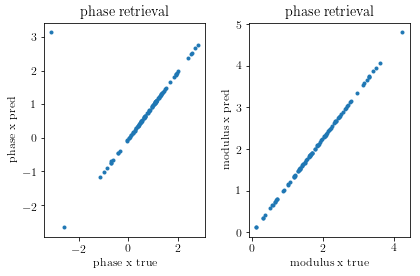

In [7]:
fig, axs = plt.subplots(1,2,sharey=False,sharex=False)
axs[0].plot(np.angle(x_true), np.angle(x_pred),'.')
axs[0].set(title="phase retrieval", xlabel="phase x true", ylabel="phase x pred")
axs[1].plot(np.absolute(x_true), np.absolute(x_pred),'.')
axs[1].set(title="phase retrieval", xlabel="modulus x true", ylabel="modulus x pred")
fig.tight_layout()

## Experiments

In [8]:
def run_phase_retrieval(N, alpha, ensemble_type, prior_type, mean_prior):
    phase_retrieval = PhaseRetrieval(
        N, alpha, ensemble_type, prior_type, mean_prior=mean_prior
    )
    scenario = TeacherStudentScenario(phase_retrieval)
    scenario.setup()
    scenario.infer()
    return dict(
        mse_ep=scenario.mse_ep["x"], n_iter_ep=scenario.n_iter_ep,
        mse_se=scenario.mse_se["x"], n_iter_se=scenario.n_iter_se,
        mse=scenario.mse["x"]
    )

In [9]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)

csv_file = "../data/phase_retrieval_experiments.csv"

def run_experiments():
    result_handler = DataFrameResultHandler()
    task = Task(
        run_phase_retrieval, 
        N=1000, ensemble_type="complex_gaussian", prior_type="gaussian",
        mean_prior=[-1, 0.5, 1, 2], alpha=np.linspace(0, 3, 150)[1:]
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    df = result_handler.get_dataframe()
    df.to_csv(csv_file, index=False)
    return df

In [10]:
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    df = run_experiments()

## Phase transition

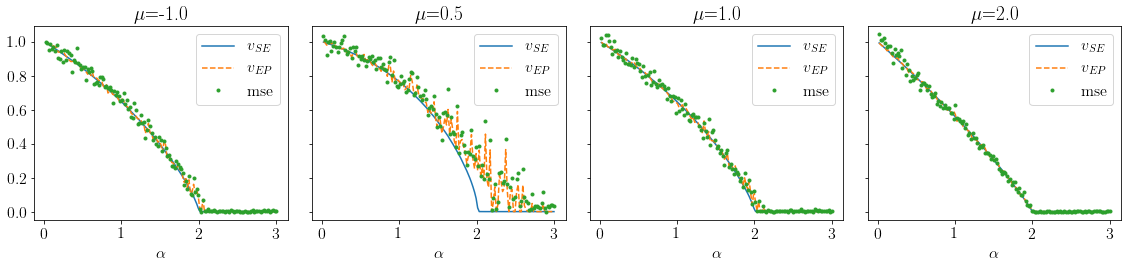

In [11]:
qplot(
    df, 
    x="alpha", y=["mse_se", "mse_ep", "mse"], y_markers=["-","--", "."], column="mean_prior", y_legend=True,
    rename={"mse_se":r"$v_{SE}$", "mse_ep":r"$v_{EP}$", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)

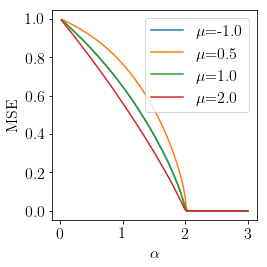

In [12]:
qplot(
    df, 
    x="alpha", y="mse_se", color="mean_prior",
    rename={"mse_se":"MSE", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)

## Nbr of iterations diverging at the critical value

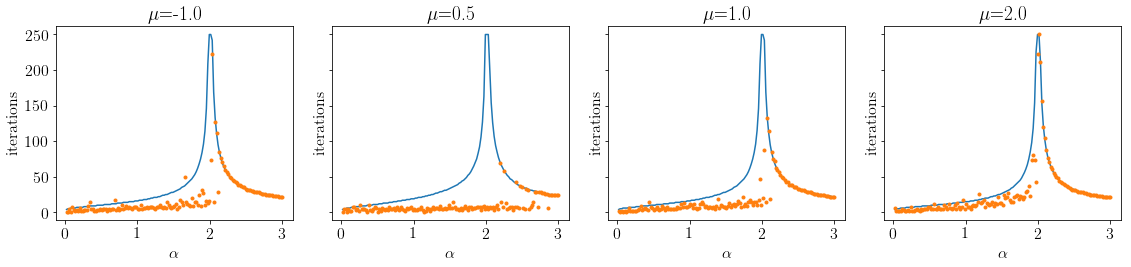

In [13]:
qplot(
    df, 
    x="alpha", y=["n_iter_se","n_iter_ep"], y_markers=["-","."], column="mean_prior",
    rename={"n_iter_se, n_iter_ep":"iterations", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)